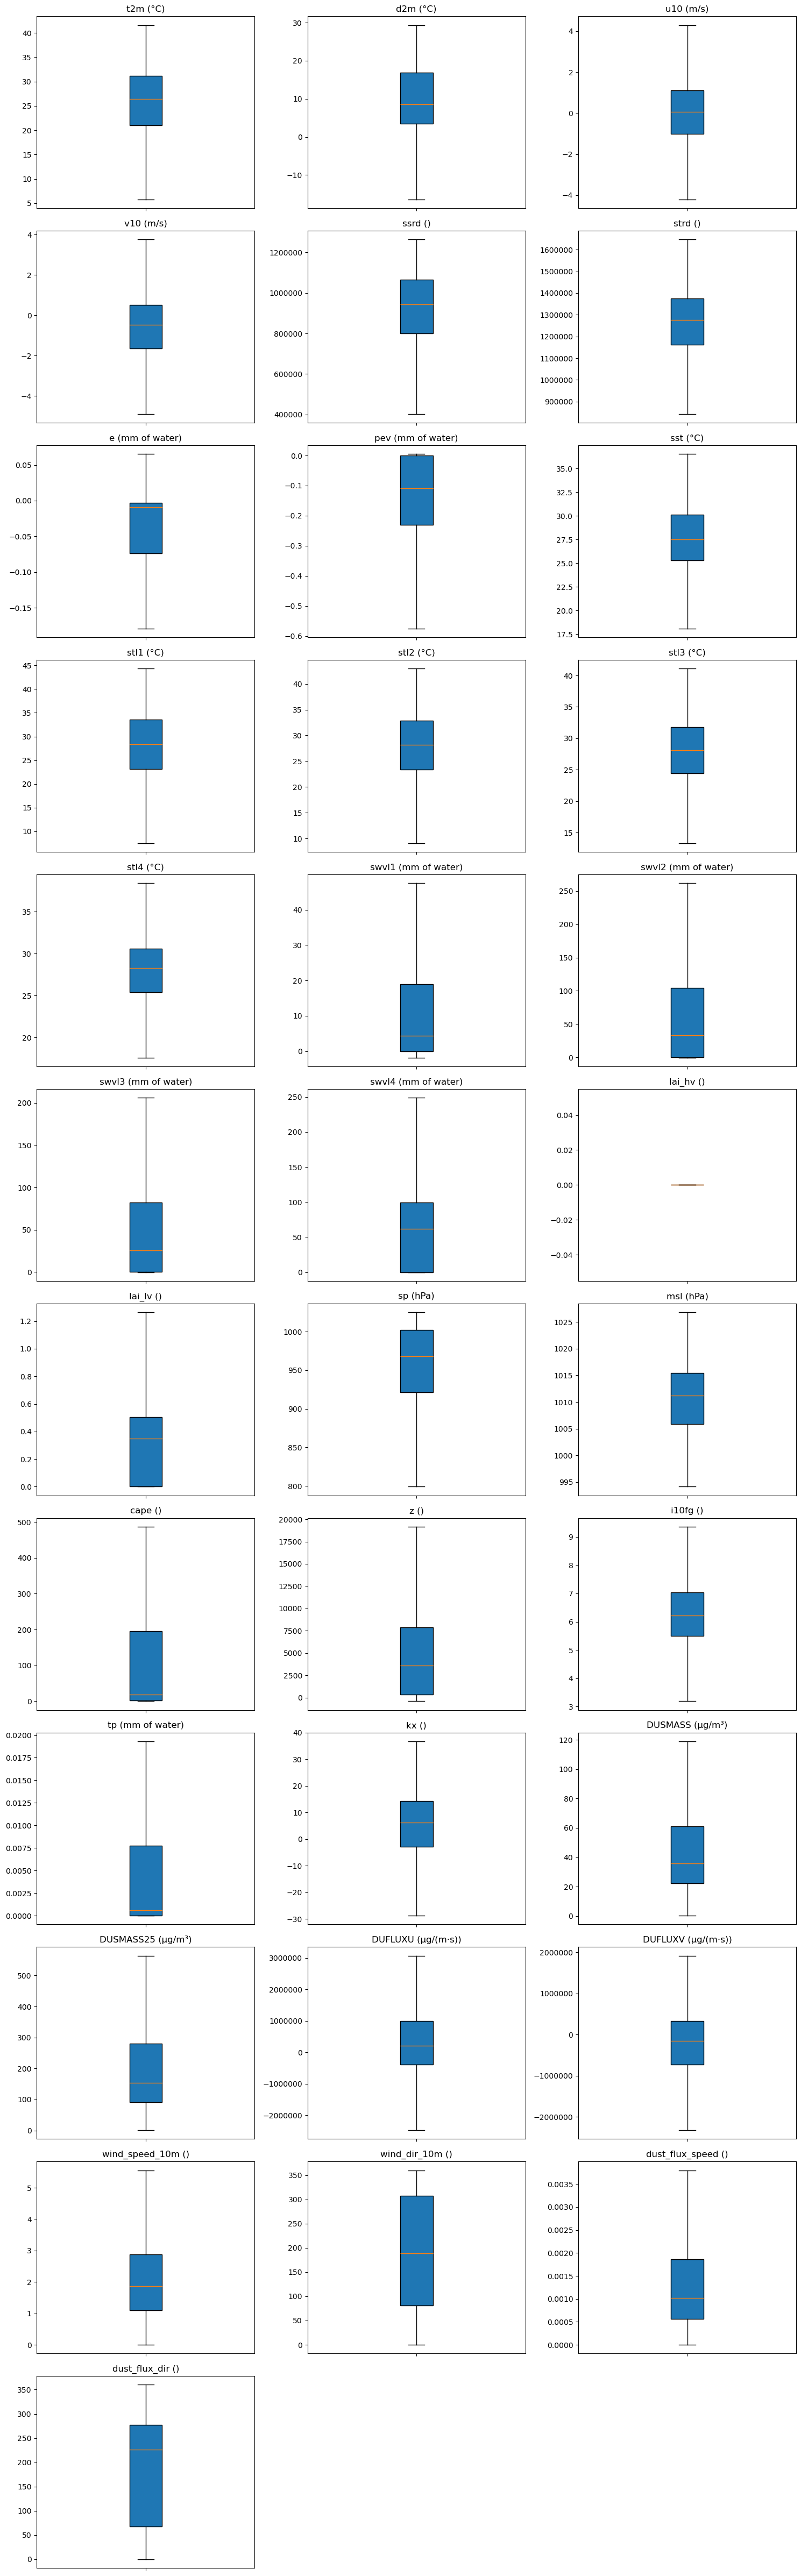

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import numpy as np

# ------------------------- CONFIGURATION -------------------------
base_path = r"Z:\Thesis\Data\ML_Data\AP_training2"
output_dir = r"Z:\Thesis\Data\test\DustCast\SFC\DC_v0063\boxplots"
os.makedirs(output_dir, exist_ok=True)

train_years = [
    1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
    1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
    2000,
    2013, 2014, 2015, 2016, 2017, 2018, 2019, 
    2020, 2021, 2022, 2023
]

countries = [
    "Yemen", 
    "Bahrain", 
    "Kuwait", 
    "Oman", 
    "Qatar", 
    "Saudi_Arabia", 
    "United_Arab_Emirates"
]

# The selected columns (all with suffixes _mean, _min, _max) you wish to process.
selected_columns = [
    "t2m_mean", 
    "d2m_mean", 
    "u10_mean", 
    "v10_mean", 
    "ssrd_mean", 
    "strd_mean", 
    "e_mean", 
    "pev_mean", 
    "sst_mean", 
    "stl1_mean", 
    "stl2_mean", 
    "stl3_mean", 
    "stl4_mean", 
    "swvl1_mean", 
    "swvl2_mean", 
    "swvl3_mean", 
    "swvl4_mean", 
    "lai_hv_mean", 
    "lai_lv_mean", 
    "sp_mean", 
    "msl_mean", 
    "cape_mean", 
    "z_mean", 
    "i10fg_mean", 
    "tp_mean", 
    "kx_mean",
    "DUSMASS_mean",
    "DUSMASS25_mean",
    "DUFLUXU_mean",
    "DUFLUXV_mean"
]

# ------------------------- PARAMETER UNITS (for reference) -------------------------
# (These will be used only as a default reference.)
param_units = {
    "t2m_mean":        "°C",
    "d2m_mean":        "°C",
    "sst_mean":        "°C",
    "stl1_mean":       "°C",
    "stl2_mean":       "°C",
    "stl3_mean":       "°C",
    "stl4_mean":       "°C",
    "u10_mean":        "m/s",
    "v10_mean":        "m/s",
    "ssrd_mean":       "J/m²",
    "strd_mean":       "J/m²",
    "e_mean":          "mm of water",
    "pev_mean":        "mm of water",
    "swvl1_mean":      "mm of water",
    "swvl2_mean":      "mm of water",
    "swvl3_mean":      "mm of water",
    "swvl4_mean":      "mm of water",
    "lai_hv_mean":     "m²/m²",
    "lai_lv_mean":     "m²/m²",
    "sp_mean":         "hPa",
    "msl_mean":        "hPa",
    "cape_mean":       "J/kg",
    "z_mean":          "m",     # may be later converted if needed
    "i10fg_mean":      "m/s",
    "tp_mean":         "mm of water",
    "kx_mean":         "K",
    "DUSMASS_mean":    "µg/m³",
    "DUSMASS25_mean":  "µg/m³",
    "DUFLUXU_mean":    "kg/(m·s)",
    "DUFLUXV_mean":    "kg/(m·s)"
}

# Temperature variables that need conversion from Kelvin to °C.
temp_vars = ["t2m", "d2m", "sst", "stl1", "stl2", "stl3", "stl4"]

# ------------------------- DATA LOADING & COMBINING -------------------------
all_dfs = []
for country in countries:
    for yr in train_years:
        file_path = os.path.join(
            base_path, 
            str(yr), 
            f"{country}_{yr}_surface_monthly_stats_merged.parquet"
        )
        if os.path.exists(file_path):
            try:
                df = pd.read_parquet(file_path)
                # Filter to the selected columns if available.
                if set(selected_columns).issubset(df.columns):
                    df = df[selected_columns]
                all_dfs.append(df)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
        else:
            print(f"File does not exist: {file_path}")

if not all_dfs:
    raise ValueError("No data files loaded!")

df_all = pd.concat(all_dfs, ignore_index=True)

# ------------------------- DATA PREPROCESSING -------------------------
# Convert all columns to numeric.
for col in df_all.columns:
    df_all[col] = pd.to_numeric(df_all[col], errors='coerce')

# ------------------------- DERIVED VARIABLES -------------------------
# (For surface data we continue to compute wind speed/direction from u10_mean and v10_mean.)
if "u10_mean" in df_all.columns and "v10_mean" in df_all.columns:
    wind_speed = np.sqrt(df_all["u10_mean"]**2 + df_all["v10_mean"]**2)
    theta_deg = np.degrees(np.arctan2(df_all["v10_mean"], df_all["u10_mean"]))
    wind_dir = (270.0 - theta_deg) % 360.0
    df_all["wind_speed_10m"] = wind_speed
    df_all["wind_dir_10m"] = wind_dir

# Similarly, dust flux speed and direction are already computed.
if "DUFLUXU_mean" in df_all.columns and "DUFLUXV_mean" in df_all.columns:
    dust_flux_speed = np.sqrt(df_all["DUFLUXU_mean"]**2 + df_all["DUFLUXV_mean"]**2)
    theta_du = np.degrees(np.arctan2(df_all["DUFLUXV_mean"], df_all["DUFLUXU_mean"]))
    dust_flux_dir = (270.0 - theta_du) % 360.0
    df_all["dust_flux_speed"] = dust_flux_speed
    df_all["dust_flux_dir"] = dust_flux_dir

# ------------------------- GROUP COLUMNS BY SUFFIX -------------------------
# We consider columns ending with _min, _max, or _mean that are in our selected_columns list.
grouped_columns = {}
for col in df_all.columns:
    for suffix in ["_min", "_max", "_mean"]:
        if col.endswith(suffix) and col in selected_columns:
            base = col[:-len(suffix)]
            if base not in grouped_columns:
                grouped_columns[base] = []
            grouped_columns[base].append(col)
            break

# ------------------------- COMBINE GROUPS & APPLY UNIT CONVERSIONS -------------------------
variable_series = {}
for base, cols in grouped_columns.items():
    # Combine all values from the grouped columns.
    combined = pd.concat([df_all[c].dropna() for c in cols])
    
    # Apply unit conversions based on the base name.
    # Temperature: if the base is one of our temp_vars.
    if base in temp_vars:
        combined = combined - 273.15
    # Water variables: convert from meters to millimeters.
    elif base in ["swvl1", "swvl2", "swvl3", "swvl4", "tp", "e", "pev"]:
        combined = combined * 1000
    # Pressure: if the base is "sp" or "msl", convert from Pa to hPa.
    elif base in ["sp", "msl"]:
        combined = combined / 100
    # Dust mass: if the base is "DUSMASS" or "DUSMASS25", convert from kg/m³ to µg/m³.
    elif base in ["DUSMASS", "DUSMASS25"]:
        combined = combined * 1e9
    # Dust flux: if the base is "DUFLUXU" or "DUFLUXV", convert from kg/(m·s) to µg/(m·s).
    elif base in ["DUFLUXU", "DUFLUXV"]:
        combined = combined * 1e9
    # Otherwise, no conversion.
    variable_series[base] = combined

# Also add derived variables (which do not follow the _min/_max/_mean pattern).
for var in ["wind_speed_10m", "wind_dir_10m", "dust_flux_speed", "dust_flux_dir"]:
    if var in df_all.columns:
        variable_series[var] = df_all[var].dropna()

# ------------------------- DEFINE UNITS FOR VARIABLES -------------------------
variable_units = {}
for base in variable_series.keys():
    if base in temp_vars:
        variable_units[base] = "°C"
    elif base in ["swvl1", "swvl2", "swvl3", "swvl4", "tp", "e", "pev"]:
        variable_units[base] = "mm of water"
    elif base in ["sp", "msl"]:
        variable_units[base] = "hPa"
    elif base in ["DUSMASS", "DUSMASS25"]:
        variable_units[base] = "µg/m³"
    elif base in ["DUFLUXU", "DUFLUXV"]:
        variable_units[base] = "µg/(m·s)"
    elif base == "u10":
        variable_units[base] = "m/s"
    elif base == "v10":
        variable_units[base] = "m/s"
    else:
        variable_units[base] = ""

# ------------------------- FACET WRAPPED BOX PLOTS -------------------------
n_vars = len(variable_series)
ncols = 3  # number of columns in the facet wrap
nrows = math.ceil(n_vars / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*4))
axes = np.array(axes).reshape(-1)  # flatten axes

for i, (base, series) in enumerate(variable_series.items()):
    ax = axes[i]
    ax.boxplot(series, notch=False, patch_artist=True, showfliers=False)
    unit = variable_units.get(base, "")
    ax.set_title(f"{base} ({unit})")
    ax.set_xticklabels([])
    ax.ticklabel_format(style='plain', axis='y', useOffset=False)

# Hide any unused subplots.
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
facet_save_path = os.path.join(output_dir, "facet_boxplots_32years_converted_adjusted_grouped.png")
plt.savefig(facet_save_path)
plt.show()
plt.close(fig)

# ------------------------- SUMMARY STATISTICS -------------------------
summary_data = []
for base, series in variable_series.items():
    summary_data.append({
        "Variable": base,
        "Mean": series.mean(),
        "Max": series.max(),
        "Min": series.min(),
        "Std": series.std(),
        "Units": variable_units.get(base, "")
    })

summary_df = pd.DataFrame(summary_data)
summary_csv_path = os.path.join(output_dir, "summary_statistics_grouped.csv")
summary_df.to_csv(summary_csv_path, index=False)


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import numpy as np

# ------------------------- CONFIGURATION -------------------------
base_path = r"Z:\Thesis\Data\ML_Data\AP_ML_training_data"
output_dir = r"Z:\Thesis\Data\test\DustCast\SFC\DC_v0063\boxplots"
os.makedirs(output_dir, exist_ok=True)

train_years = [
    1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
    1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
    2000,
    2013, 2014, 2015, 2016, 2017, 2018, 2019, 
    2020, 2021, 2022, 2023
]

countries = [
    "Yemen", 
    "Bahrain", 
    "Kuwait", 
    "Oman", 
    "Qatar", 
    "Saudi_Arabia", 
    "United_Arab_Emirates"
]

# Selected columns to average (and eventually plot)
selected_columns = [
    "t2m_mean", 
    "d2m_mean", 
    "u10_mean", 
    "v10_mean", 
    "ssrd_mean", 
    "strd_mean", 
    "e_mean", 
    "pev_mean", 
    "sst_mean", 
    "stl1_mean", 
    "stl2_mean", 
    "stl3_mean", 
    "stl4_mean", 
    "swvl1_mean", 
    "swvl2_mean", 
    "swvl3_mean", 
    "swvl4_mean", 
    "lai_hv_mean", 
    "lai_lv_mean", 
    "sp_mean", 
    "msl_mean", 
    "cape_mean", 
    "z_mean", 
    "i10fg_mean", 
    "tp_mean", 
    "kx_mean",
    "DUSMASS_mean",
    "DUSMASS25_mean",
    "DUFLUXU_mean",
    "DUFLUXV_mean"
]

# ------------------------- PARAMETER UNITS -------------------------
# These units are as provided by MERRA-2. We will adjust units during conversion.
param_units = {
    # Temperatures (in K; will be converted to °C)
    "t2m_mean":        "K",
    "d2m_mean":        "K",
    "sst_mean":        "K",
    "stl1_mean":       "K",
    "stl2_mean":       "K",
    "stl3_mean":       "K",
    "stl4_mean":       "K",
    
    # Wind components
    "u10_mean":        "m/s",
    "v10_mean":        "m/s",
    
    # Radiation (accumulated energy)
    "ssrd_mean":       "J/m^2",
    "strd_mean":       "J/m^2",
    
    # Evaporation
    "e_mean":          "m of water",
    "pev_mean":        "m of water",
    
    # Soil moisture, LAI, etc.
    "swvl1_mean":      "m^3/m^3",
    "swvl2_mean":      "m^3/m^3",
    "swvl3_mean":      "m^3/m^3",
    "swvl4_mean":      "m^3/m^3",
    "lai_hv_mean":     "m^2/m^2",
    "lai_lv_mean":     "m^2/m^2",
    
    # Pressure & others
    "sp_mean":         "Pa",
    "msl_mean":        "Pa",
    "cape_mean":       "J/kg",
    "z_mean":          "m",
    "i10fg_mean":      "m/s",
    "tp_mean":         "m of water",
    "kx_mean":         "K",      # K-index
    
    # Dust mass concentrations (in kg/m³; will be converted to µg/m³)
    "DUSMASS_mean":    "kg/m^3",
    "DUSMASS25_mean":  "kg/m^3",
    
    # Dust flux (in kg/(m·s); will be converted to µg/(m·s))
    "DUFLUXU_mean":    "kg/(m·s)",
    "DUFLUXV_mean":    "kg/(m·s)"
}

# Temperature variables to convert from Kelvin to °C
temp_vars = [
    "t2m_mean", "d2m_mean", "sst_mean", 
    "stl1_mean", "stl2_mean", "stl3_mean", "stl4_mean"
]

# ------------------------- DATA LOADING & COMBINING -------------------------
all_dfs = []
for country in countries:
    for yr in train_years:
        file_path = os.path.join(
            base_path, 
            str(yr), 
            f"{country}_{yr}_surface_monthly_stats_merged.parquet"
        )
        if os.path.exists(file_path):
            try:
                df = pd.read_parquet(file_path)
                # Filter to selected columns if available
                if set(selected_columns).issubset(df.columns):
                    df = df[selected_columns]
                all_dfs.append(df)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
        else:
            print(f"File does not exist: {file_path}")

if not all_dfs:
    raise ValueError("No data files loaded!")

# Combine all dataframes into one
df_all = pd.concat(all_dfs, ignore_index=True)

# ------------------------- DATA PREPROCESSING -------------------------
# Ensure all columns are numeric
for col in df_all.columns:
    df_all[col] = pd.to_numeric(df_all[col], errors='coerce')

# ------------------------- DERIVED VARIABLES -------------------------
# Compute wind speed and direction from u10_mean and v10_mean.
if "u10_mean" in df_all.columns and "v10_mean" in df_all.columns:
    wind_speed = np.sqrt(df_all["u10_mean"]**2 + df_all["v10_mean"]**2)
    theta_deg = np.degrees(np.arctan2(df_all["v10_mean"], df_all["u10_mean"]))
    wind_dir = (270.0 - theta_deg) % 360.0
    df_all["wind_speed_10m"] = wind_speed
    df_all["wind_dir_10m"] = wind_dir

# Compute dust flux speed and direction from DUFLUXU_mean and DUFLUXV_mean.
if "DUFLUXU_mean" in df_all.columns and "DUFLUXV_mean" in df_all.columns:
    dust_flux_speed = np.sqrt(df_all["DUFLUXU_mean"]**2 + df_all["DUFLUXV_mean"]**2)
    theta_du = np.degrees(np.arctan2(df_all["DUFLUXV_mean"], df_all["DUFLUXU_mean"]))
    dust_flux_dir = (270.0 - theta_du) % 360.0
    df_all["dust_flux_speed"] = dust_flux_speed
    df_all["dust_flux_dir"] = dust_flux_dir

# ------------------------- EXTRACT VARIABLE SERIES -------------------------
# For most variables we use the "_mean" column.
variable_series = {}
for col in df_all.columns:
    if col.endswith("_mean") and col in selected_columns:
        base = col[:-5]  # e.g., "t2m" from "t2m_mean"
        series = df_all[col].dropna()
        # Convert temperatures from Kelvin to °C
        if col in temp_vars:
            series = series - 273.15
        # Convert dust mass concentrations from kg/m³ to µg/m³
        if col in ["DUSMASS_mean", "DUSMASS25_mean"]:
            series = series * 1e9
        variable_series[base] = series

# Add derived variables.
# For dust flux speed, convert from kg/(m·s) to µg/(m·s)
for var in ["wind_speed_10m", "wind_dir_10m", "dust_flux_speed", "dust_flux_dir"]:
    if var in df_all.columns:
        series = df_all[var].dropna()
        if var == "dust_flux_speed":
            series = series * 1e9  # convert to µg/(m·s)
        variable_series[var] = series

# ------------------------- DEFINE UNITS FOR VARIABLES -------------------------
variable_units = {}
for key in variable_series:
    if key == "wind_speed_10m":
        variable_units[key] = "m/s"
    elif key == "wind_dir_10m":
        variable_units[key] = "deg_from_N"
    elif key == "dust_flux_speed":
        variable_units[key] = "µg/(m·s)"
    elif key == "dust_flux_dir":
        variable_units[key] = "deg_from_N"
    elif key in ["DUSMASS", "DUSMASS25"]:
        variable_units[key] = "µg/m³"
    else:
        mean_key = key + "_mean"
        # For non-converted variables, use param_units
        variable_units[key] = param_units.get(mean_key, "")

# ------------------------- FACET WRAPPED BOX PLOTS -------------------------
n_vars = len(variable_series)
ncols = 3  # number of columns in the facet wrap
nrows = math.ceil(n_vars / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*4))
axes = np.array(axes).reshape(-1)  # flatten axes array

for i, (base, series) in enumerate(variable_series.items()):
    ax = axes[i]
    # Create a standard boxplot (showing quartiles, median, whiskers, and outliers)
    ax.boxplot(series, notch=False, patch_artist=True)
    unit = variable_units.get(base, "")
    ax.set_title(f"{base} ({unit})")
    # Optionally remove x-axis tick labels to reduce clutter.
    ax.set_xticklabels([])

# Hide any unused subplots in the grid.
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
#facet_save_path = os.path.join(output_dir, "facet_boxplots_32years_converted.png")
#plt.savefig(facet_save_path)
plt.show()
#plt.close(fig)


KeyboardInterrupt: 

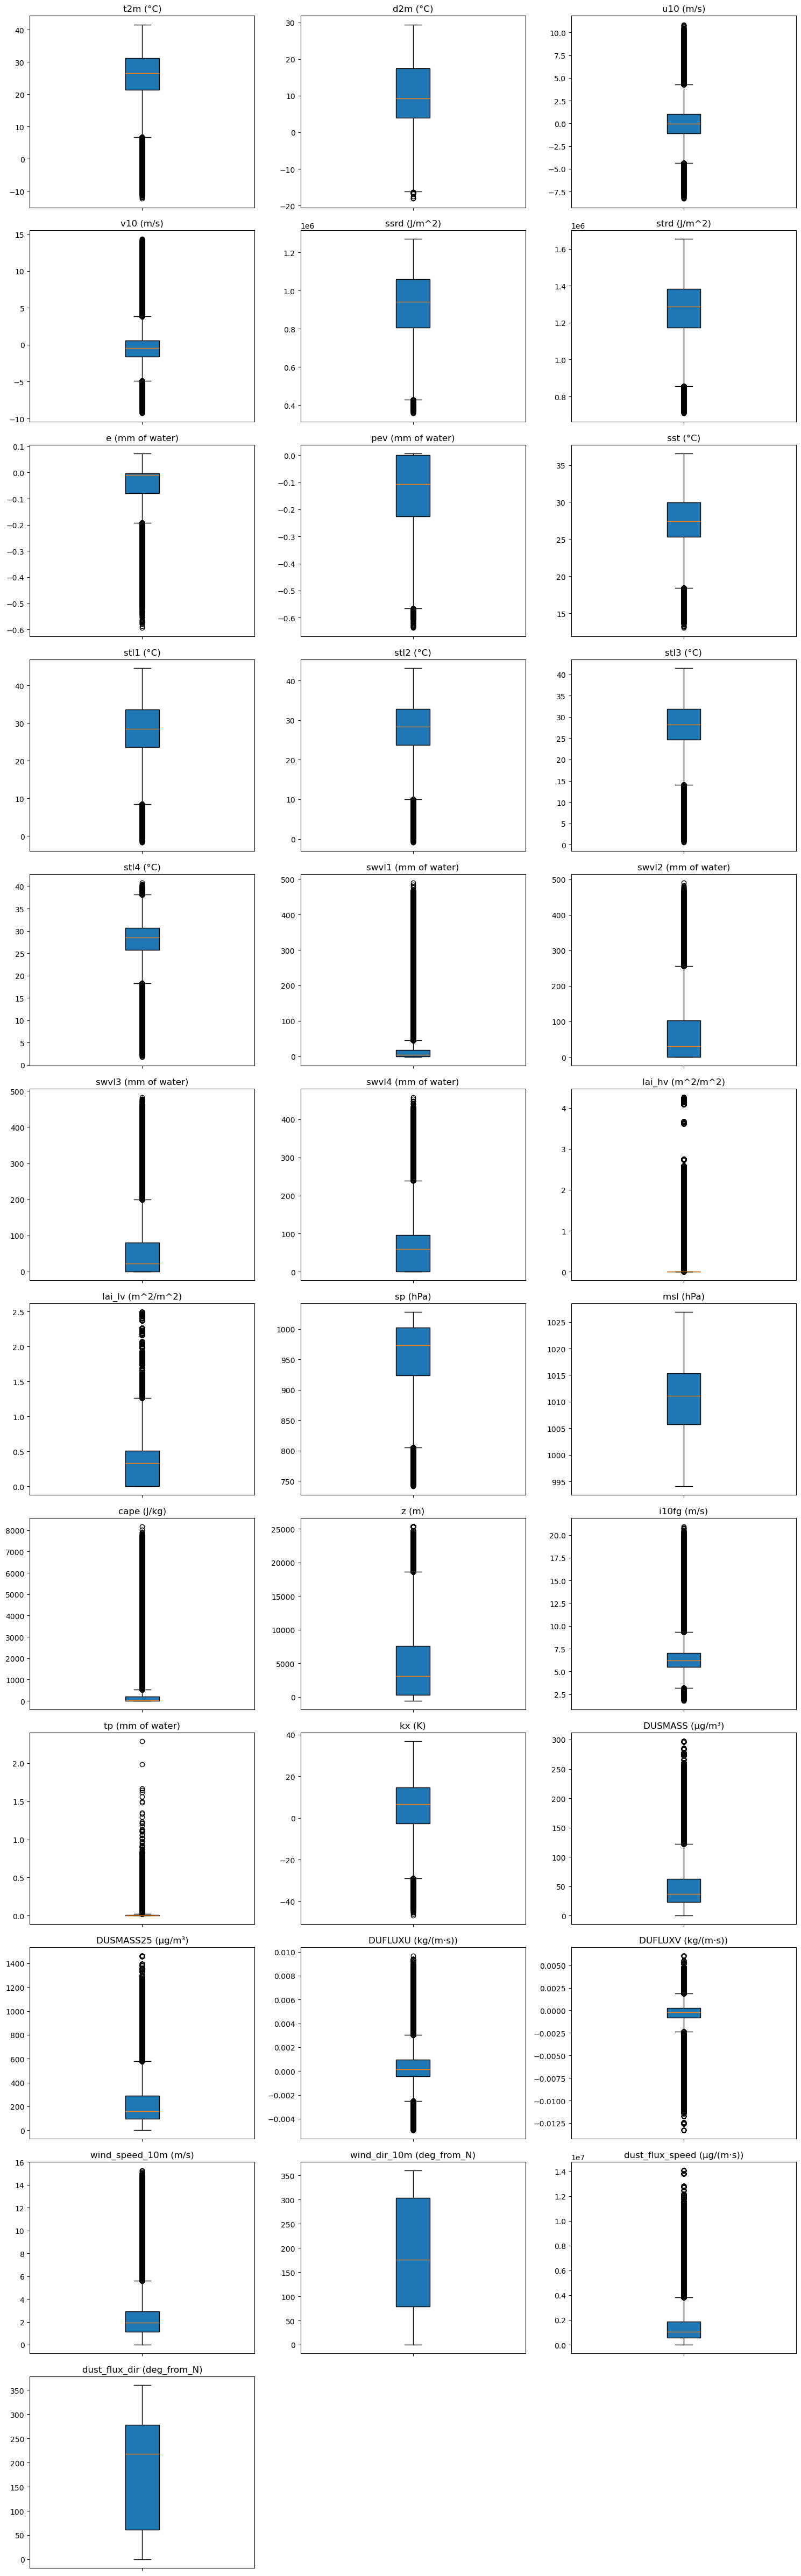

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import numpy as np

# ------------------------- CONFIGURATION -------------------------
base_path = r"Z:\Thesis\Data\ML_Data\AP_ML_training_data"
output_dir = r"Z:\Thesis\Data\test\DustCast\SFC\DC_v0063\boxplots"
os.makedirs(output_dir, exist_ok=True)

train_years = [
    1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
    1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
    2000,
    2013, 2014, 2015, 2016, 2017, 2018, 2019, 
    2020, 2021, 2022, 2023
]

countries = [
    "Yemen", 
    "Bahrain", 
    "Kuwait", 
    "Oman", 
    "Qatar", 
    "Saudi_Arabia", 
    "United_Arab_Emirates"
]

# Selected columns to average (and eventually plot)
selected_columns = [
    "t2m_mean", 
    "d2m_mean", 
    "u10_mean", 
    "v10_mean", 
    "ssrd_mean", 
    "strd_mean", 
    "e_mean", 
    "pev_mean", 
    "sst_mean", 
    "stl1_mean", 
    "stl2_mean", 
    "stl3_mean", 
    "stl4_mean", 
    "swvl1_mean", 
    "swvl2_mean", 
    "swvl3_mean", 
    "swvl4_mean", 
    "lai_hv_mean", 
    "lai_lv_mean", 
    "sp_mean", 
    "msl_mean", 
    "cape_mean", 
    "z_mean", 
    "i10fg_mean", 
    "tp_mean", 
    "kx_mean",
    "DUSMASS_mean",
    "DUSMASS25_mean",
    "DUFLUXU_mean",
    "DUFLUXV_mean"
]

# ------------------------- PARAMETER UNITS -------------------------
# Define the original units, then we update after conversion.
param_units = {
    # Temperatures (in K; will be converted to °C)
    "t2m_mean":        "°C",  # label updated to °C after conversion
    "d2m_mean":        "°C",
    "sst_mean":        "°C",
    "stl1_mean":       "°C",
    "stl2_mean":       "°C",
    "stl3_mean":       "°C",
    "stl4_mean":       "°C",
    
    # Wind components
    "u10_mean":        "m/s",
    "v10_mean":        "m/s",
    
    # Radiation (accumulated energy)
    "ssrd_mean":       "J/m^2",
    "strd_mean":       "J/m^2",
    
    # Evaporation (in m; will be converted to mm)
    "e_mean":          "mm of water",
    "pev_mean":        "mm of water",
    
    # Soil moisture, LAI, etc. (assumed to be volumetric; no unit change)
    "swvl1_mean":      "mm of water",   # converted from m to mm
    "swvl2_mean":      "mm of water",
    "swvl3_mean":      "mm of water",
    "swvl4_mean":      "mm of water",
    "lai_hv_mean":     "m^2/m^2",
    "lai_lv_mean":     "m^2/m^2",
    
    # Pressure & others
    "sp_mean":         "hPa",   # converted from Pa to hPa
    "msl_mean":        "hPa",
    "cape_mean":       "J/kg",
    "z_mean":          "m",
    "i10fg_mean":      "m/s",
    "tp_mean":         "mm of water",  # converted from m to mm
    "kx_mean":         "K",      # K-index (remains K)
    
    # Dust mass concentrations (in kg/m³; convert to µg/m³)
    "DUSMASS_mean":    "µg/m³",
    "DUSMASS25_mean":  "µg/m³",
    
    # Dust flux (in kg/(m·s); convert to µg/(m·s))
    "DUFLUXU_mean":    "kg/(m·s)",  # components; we derive dust_flux_speed below
    "DUFLUXV_mean":    "kg/(m·s)"
}

# Temperature variables to convert from Kelvin to °C
temp_vars = [
    "t2m_mean", "d2m_mean", "sst_mean", 
    "stl1_mean", "stl2_mean", "stl3_mean", "stl4_mean"
]

# ------------------------- DATA LOADING & COMBINING -------------------------
all_dfs = []
for country in countries:
    for yr in train_years:
        file_path = os.path.join(
            base_path, 
            str(yr), 
            f"{country}_{yr}_surface_monthly_stats_merged.parquet"
        )
        if os.path.exists(file_path):
            try:
                df = pd.read_parquet(file_path)
                # Filter to selected columns if available
                if set(selected_columns).issubset(df.columns):
                    df = df[selected_columns]
                all_dfs.append(df)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
        else:
            print(f"File does not exist: {file_path}")

if not all_dfs:
    raise ValueError("No data files loaded!")

# Combine all dataframes into one
df_all = pd.concat(all_dfs, ignore_index=True)

# ------------------------- DATA PREPROCESSING -------------------------
# Ensure all columns are numeric
for col in df_all.columns:
    df_all[col] = pd.to_numeric(df_all[col], errors='coerce')

# ------------------------- DERIVED VARIABLES -------------------------
# Compute wind speed and direction from u10_mean and v10_mean.
if "u10_mean" in df_all.columns and "v10_mean" in df_all.columns:
    wind_speed = np.sqrt(df_all["u10_mean"]**2 + df_all["v10_mean"]**2)
    theta_deg = np.degrees(np.arctan2(df_all["v10_mean"], df_all["u10_mean"]))
    wind_dir = (270.0 - theta_deg) % 360.0
    df_all["wind_speed_10m"] = wind_speed
    df_all["wind_dir_10m"] = wind_dir

# Compute dust flux speed and direction from DUFLUXU_mean and DUFLUXV_mean.
if "DUFLUXU_mean" in df_all.columns and "DUFLUXV_mean" in df_all.columns:
    dust_flux_speed = np.sqrt(df_all["DUFLUXU_mean"]**2 + df_all["DUFLUXV_mean"]**2)
    theta_du = np.degrees(np.arctan2(df_all["DUFLUXV_mean"], df_all["DUFLUXU_mean"]))
    dust_flux_dir = (270.0 - theta_du) % 360.0
    df_all["dust_flux_speed"] = dust_flux_speed
    df_all["dust_flux_dir"] = dust_flux_dir

# ------------------------- EXTRACT VARIABLE SERIES -------------------------
# For most variables we use the "_mean" column. We'll apply additional conversions:
variable_series = {}
for col in df_all.columns:
    if col.endswith("_mean") and col in selected_columns:
        base = col[:-5]  # e.g., "t2m" from "t2m_mean"
        series = df_all[col].dropna()
        # Temperature: convert from Kelvin to °C.
        if col in temp_vars:
            series = series - 273.15
        # Water variables: convert from meters to millimeters.
        if col in ["swvl1_mean", "swvl2_mean", "swvl3_mean", "swvl4_mean", "tp_mean", "e_mean", "pev_mean"]:
            series = series * 1000
        # Pressure variables: convert from Pa to hPa.
        if col in ["sp_mean", "msl_mean"]:
            series = series / 100
        # Dust mass concentrations: convert from kg/m³ to µg/m³.
        if col in ["DUSMASS_mean", "DUSMASS25_mean"]:
            series = series * 1e9
        variable_series[base] = series

# Add derived variables.
# For dust flux speed, convert from kg/(m·s) to µg/(m·s)
for var in ["wind_speed_10m", "wind_dir_10m", "dust_flux_speed", "dust_flux_dir"]:
    if var in df_all.columns:
        series = df_all[var].dropna()
        if var == "dust_flux_speed":
            series = series * 1e9  # convert to µg/(m·s)
        variable_series[var] = series

# ------------------------- DEFINE UNITS FOR VARIABLES -------------------------
variable_units = {}
for key in variable_series:
    if key == "wind_speed_10m":
        variable_units[key] = "m/s"
    elif key == "wind_dir_10m":
        variable_units[key] = "deg_from_N"
    elif key == "dust_flux_speed":
        variable_units[key] = "µg/(m·s)"
    elif key == "dust_flux_dir":
        variable_units[key] = "deg_from_N"
    # For dust mass, keys will be like "DUSMASS" (from "DUSMASS_mean")
    elif key in ["DUSMASS", "DUSMASS25", "DUSFLUXU", "DUSFLUXV"]:
        variable_units[key] = "µg/m³"
    elif key in ["swvl1", "swvl2", "swvl3", "swvl4", "tp", "e", "pev"]:
        variable_units[key] = "mm of water"
    elif key in ["sp", "msl"]:
        variable_units[key] = "hPa"
    elif key in ["t2m", "d2m", "sst", "stl1", "stl2", "stl3", "stl4"]:
        variable_units[key] = "°C"
    else:
        mean_key = key + "_mean"
        variable_units[key] = param_units.get(mean_key, "")

# ------------------------- FACET WRAPPED BOX PLOTS -------------------------
n_vars = len(variable_series)
ncols = 3  # number of columns in the facet wrap
nrows = math.ceil(n_vars / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*4))
axes = np.array(axes).reshape(-1)  # flatten axes array

for i, (base, series) in enumerate(variable_series.items()):
    ax = axes[i]
    # Create a standard boxplot (displaying quartiles, median, whiskers, and outliers)
    ax.boxplot(series, notch=False, patch_artist=True)
    unit = variable_units.get(base, "")
    ax.set_title(f"{base} ({unit})")
    # Optionally remove x-axis tick labels to reduce clutter.
    ax.set_xticklabels([])

# Hide any unused subplots in the grid.
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
facet_save_path = os.path.join(output_dir, "facet_boxplots_32years_converted_adjusted.png")
plt.savefig(facet_save_path)
plt.show()
plt.close(fig)
